In [1]:
import sys
import json
import math
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import random

In [2]:
file_csi_nobody = "log.csi.nobody.csv"
df_csi_nobody = pd.read_csv(file_csi_nobody)

file_csi_1p = "log.csi.1person.csv"
df_csi_1p = pd.read_csv(file_csi_1p)

file_csi_2p = "log.csi.2person.csv"
df_csi_2p = pd.read_csv(file_csi_2p)

# file_ftm_nobody = "log.ftm.nobody.csv"
# df_ftm_nobody = pd.read_csv(file_ftm_nobody)

# file_ftm_1p = "log.ftm.1person.csv"
# df_ftm_1p = pd.read_csv(file_ftm_1p)

# file_ftm_2p = "log.csi.2person.csv"
# df_ftm_2p = pd.read_csv(file_ftm_2p)

In [3]:
# ftm have some format issue that needs to be corrected
# print(df_ftm_nobody)

(0.0, 1000.0, -100.0, 0.0)

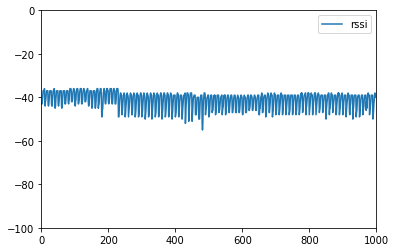

In [4]:
df_rssi = df_csi_nobody.loc[:, ['rssi']]
df_rssi.plot(y=['rssi'])
plt.axis([0, len(df_rssi.index), -100, 0])

In [5]:
df_csi = df_csi_nobody.loc[:, ['len', 'data']]
print(df_csi)

     len                                               data
0    128  [0,0,0,-10,0,-10,-1,-10,-1,-9,-1,-9,-1,-9,-1,-...
1    128  [0,0,-10,1,-10,1,-10,1,-10,1,-9,1,-9,2,-9,2,-9...
2    128  [0,0,8,1,8,1,8,1,8,1,8,0,8,0,8,0,8,-1,7,-1,8,-...
3    128  [0,0,1,8,1,8,1,8,1,8,2,8,2,8,3,8,3,8,3,8,4,8,5...
4    128  [0,0,9,-2,9,-3,9,-2,9,-3,9,-3,9,-3,9,-3,9,-3,9...
..   ...                                                ...
995  128  [0,0,5,9,5,9,5,9,5,9,5,9,5,9,5,8,5,8,5,8,5,7,6...
996  128  [0,0,6,7,-1,8,0,5,4,12,5,4,-1,9,0,7,6,9,4,10,3...
997  128  [0,0,-6,-8,-6,-8,-6,-7,-6,-7,-6,-7,-6,-6,-7,-6...
998  128  [0,0,7,5,7,5,7,5,7,5,7,5,7,5,7,4,7,4,8,3,8,3,8...
999  128  [0,0,-10,2,-10,3,-10,3,-10,3,-9,3,-9,3,-9,3,-8...

[1000 rows x 2 columns]


In [6]:
# subcarrier 1-26, 38-63 are valid subcarriers
select_list = []
select_list += range(1,27)
select_list += range(38,64)

In [7]:
def get_csi_phase_amp(df_dataframe):
    size_x = len(df_dataframe.index)
    size_y = df_dataframe.iloc[0]['len'] // 2
    csi_imag = np.zeros([size_x, size_y])
    csi_real = np.zeros([size_x, size_y])
    csi_amp = np.zeros([size_x, size_y], dtype=np.float64)
    csi_ang = np.zeros([size_x, size_y], dtype=np.float64)

    for x, csi in enumerate(df_dataframe.iloc):
            csi_raw_data = json.loads(csi['data'])
            
            for y in range(0, len(csi_raw_data)):
                if y%2 == 0:
                    csi_imag[x][y//2] = csi_raw_data[y]
                else:
                    csi_real[x][y//2] = csi_raw_data[y]

            for i in range(0, len(csi_raw_data)//2):
                if i < len(csi_raw_data)//4:
                    csi_amp[x][i+32] = math.sqrt(pow(csi_imag[x][i], 2) + pow(csi_real[x][i], 2))
                    csi_ang[x][i+32] = math.atan2(csi_imag[x][i], csi_real[x][i])
                else:
                    csi_amp[x][i-32] = math.sqrt(pow(csi_imag[x][i], 2) + pow(csi_real[x][i], 2))
                    csi_ang[x][i-32] = math.atan2(csi_imag[x][i], csi_real[x][i])

    columns = [f"subcarrier{i}" for i in range(-32, 32)]
    df_csi_amp = pd.DataFrame(csi_amp, columns=columns)
    df_csi_phase = pd.DataFrame(csi_ang, columns=columns)
    df_csi_amp_valid = pd.DataFrame()
    df_csi_phase_valid = pd.DataFrame()

# trim the valid csi data
    for i in select_list:
        if i > 0:
            df_csi_amp_valid[f"subcarrier{i}"] = df_csi_amp[f"subcarrier{i}"]
            df_csi_phase_valid[f"subcarrier{i}"] = df_csi_phase[f"subcarrier{i}"]
        if i < 0:
            df_csi_amp_valid[f"subcarrier{i}"] = df_csi_amp[f"subcarrier{i}"]
            df_csi_phase_valid[f"subcarrier{i}"] = df_csi_phase[f"subcarrier{i}"]
#         df_csi_amplitude_valid[f"subcarrier{i}"] = df_csi_amplitude[f"subcarrier{i}"]
    
#     return df_csi_valid, df_csi_phase_valid_raw, df_csi_amplitude_valid
#     return df_csi_amp, df_csi_phase, df_csi_amp_tmp, df_csi_phase_tmp
    return df_csi_amp_valid, df_csi_phase_valid

In [8]:
def sort_zero_sub_with_truth(df_dataframe, select_list, divide_index, truth):
    # collect zero subcarrier across all csi data
    zero_sub_data = []
    for i in range(df_dataframe.shape[0]):
        y = []
        for j in select_list:
    #             print(df_csi_phase_valid[f"subcarrier{j}"])
            y.append(df_dataframe.iloc[i][f"subcarrier{j}"])
        x = select_list
        cs_y = CubicSpline(x,y,bc_type='natural')
#         y.append(cs_y(32))
        if cs_y(32) < 0:
            zero_sub_data.append(-abs(cs_y(32)))
        else:
            zero_sub_data.append(abs(cs_y(32)))
#         zero_sub_data.append(z)
#     print(len(zero_sub_data))

    data_by_event = []
    data_only = []
    for i in range(df_dataframe.shape[0]//divide_index):
        x = []
        for j in range(divide_index):
            x.append(zero_sub_data[10*i+j])
        data_only.append(x)
#         data_by_event.append([x,truth])
            
#     print(data_only)
    return data_only

In [9]:
zero_amp_valid, zero_phase_valid = get_csi_phase_amp(df_csi_nobody)
# one_amp_valid, one_phase_valid = get_csi_phase_amp(df_csi_1p)
 # two_phase_valid, two_amp_valid = get_csi_phase_amp(df_csi_2p)

In [10]:
#zero_phase_by_event_truth = sort_zero_sub_with_truth(zero_phase_valid, select_list, 10, 0)
#zero_amp_by_event_truth = sort_zero_sub_with_truth(zero_amp_valid, select_list, 10, 0)
#zero_valid_w_truth = sort_zero_sub_with_truth(zero_csi_valid, select_list, 10, 0)

#one_phase_by_event_truth = sort_zero_sub_with_truth(one_phase_valid, select_list, 10, 1)
#one_amp_by_event_truth = sort_zero_sub_with_truth(one_amp_valid, select_list, 10, 1)
#one_valid_w_truth = sort_zero_sub_with_truth(one_csi_valid, select_list, 10, 1)

#two_phase_by_event_truth = sort_zero_sub_with_truth(two_phase_valid, select_list, 10, 2)
#two_amp_by_event_truth = sort_zero_sub_with_truth(two_amp_valid, select_list, 10, 2)
#two_valid_w_truth = sort_zero_sub_with_truth(two_csi_valid, select_list, 10, 2)

In [11]:
all_phase_data = []
#for i in range(len(zero_phase_by_event_truth)):
#    all_phase_data.append(zero_phase_by_event_truth[i])
#     all_phase_data.append(one_phase_by_event_truth[i])
#     all_phase_data.append(two_phase_by_event_truth[i])
# random shuffle the data
# random.shuffle(all_phase_data)

#all_amp_data = []
#for i in range(len(zero_phase_by_event_truth)):
 #   all_amp_data.append(zero_amp_by_event_truth[i])
#     all_amp_data.append(one_amp_by_event_truth[i])
#     all_amp_data.append(two_amp_by_event_truth[i])
# random shuffle the data
# random.shuffle(all_amp_data)

#all_csi_data = []
#for i in range(len(zero_phase_by_event_truth)):
#    all_csi_data.append(zero_valid_w_truth[i])
#     all_csi_data.append(one_valid_w_truth[i])
#     all_csi_data.append(two_valid_w_truth[i])
# random shuffle the data
# random.shuffle(all_csi_data)

# 到这儿所有的data处理应该都完成了，每个list中每个元素的格式是：【【十个数，每channel的central subcarrier的amp/phase】，0/1/2取决于ground truth】

In [12]:
with open('csi_phase_processed_data.csv', 'w') as filehandle:
    for item in all_phase_data:
        item_str = str(item)
        print(item_str)
        filehandle.writelines("%s\n" % item_str[1:-1])
    filehandle.writelines("%s\n" % place for place in all_phase_data)
filehandle.close()

#with open('csi_amp_processed_data.csv', 'w') as filehandle:
#     for item in all_amp_data:
 #       item_str = str(item)
#        print(item_str)
 #       filehandle.writelines("%s\n" % item_str[1:-1])
#     filehandle.writelines("%s\n" % place for place in all_amp_data)
#filehandle.close()

#with open('csi_abs_processed_data.csv', 'w') as filehandle:
#     for item in all_csi_data:
#        item_str = str(item)
#        print(item_str)
 #       filehandle.writelines("%s\n" % item_str[1:-1])
#     filehandle.writelines("%s\n" % place for place in all_csi_data)
#filehandle.close()